In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json
import polars as pl

In [12]:
# Common plotting settings
plt.rcParams.update({
    'font.size': 12,         # Base font size
    'axes.labelsize': 14,    # Font size for x and y labels
    'axes.titlesize': 16,    # Font size for the title
    'xtick.labelsize': 12,   # Font size for x-axis tick labels
    'ytick.labelsize': 12,   # Font size for y-axis tick labels
    'legend.fontsize': 12,   # Font size for legend
    'figure.dpi': 300,       # Default DPI for displayed figures
    'savefig.dpi': 300       # Default DPI for saved figures
})

#### For 9 EVSE based charging depot for fleet charging

In [24]:
# Read simulation_data_for_journal_paper.csv
df = pd.read_csv('simulation_data_for_journal_paper.csv')
df = df.rename(columns={'Number of charger': 'NumberOfChargers',
                'Number of priority evs': 'NumberOfPriorityEVs',
                'Total number of EV': 'TotalEVs',
                'Total charging cost: withoutSmartCharging': 'ChargingCost_uncontrolled',
                'Total charging cost: RR': 'ChargingCost_RoundRobin',
                'Total charging cost: LLF': 'ChargingCost_LeastLaxityFirst',
                'Total charging cost: MPC': 'ChargingCost_MPC',})
df = df[df['NumberOfChargers'] == 9]
df.head(20)

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC,Priority EV served (%): withoutSmartCharging,Priority EV served (%): RR,Priority EV served (%): LLF,Priority EV served (%): MPC
0,9,85,7,25,25.146,20.129,20.099,21.1,100,97,97.0,100
1,9,95,7,25,27.000,20.129,20.129,21.0,100,97,97.0,100
2,9,105,7,25,27.000,20.200,20.500,21.0,100,97,97.0,100


In [26]:
# Calculate the ratio of priority EVs to total EVs
df['priority_ev_ratio'] = (df['NumberOfPriorityEVs'] / df['TotalEVs']).round(3)
df

,NumberOfChargers,Transformer capacity,NumberOfPriorityEVs,TotalEVs,ChargingCost_uncontrolled,ChargingCost_RoundRobin,ChargingCost_LeastLaxityFirst,ChargingCost_MPC,Priority EV served (%): withoutSmartCharging,Priority EV served (%): RR,Priority EV served (%): LLF,Priority EV served (%): MPC,priority_ev_ratio
0,9,85,7,25,25.146,20.129,20.099,21.1,100,97,97.0,100,0.28
1,9,95,7,25,27.000,20.129,20.129,21.0,100,97,97.0,100,0.28
2,9,105,7,25,27.000,20.200,20.500,21.0,100,97,97.0,100,0.28


In [27]:
# reshape (melt) the dataframe to have a long format
df_melted = df.melt(id_vars=['TotalEVs', 'priority_ev_ratio'],
                    value_vars=['ChargingCost_uncontrolled', 'ChargingCost_RoundRobin', 'ChargingCost_LeastLaxityFirst', 'ChargingCost_MPC'],
                    var_name='ChargingStrategy',
                    value_name='ChargingCost')
df_melted['ChargingStrategy'] = df_melted['ChargingStrategy'].str.replace('ChargingCost_', '')

In [28]:
# Make ratio categorical for distinct bars, especially for few unique ratio values
# or if they are very close numerically to avoid making x-axis messy.
df_melted['priority_ev_ratio_cat'] = df_melted['priority_ev_ratio'].round(3).astype(str)
# Sort by the original numeric ratio to ensure logical order on the x-axis
df_melted = df_melted.sort_values('priority_ev_ratio')

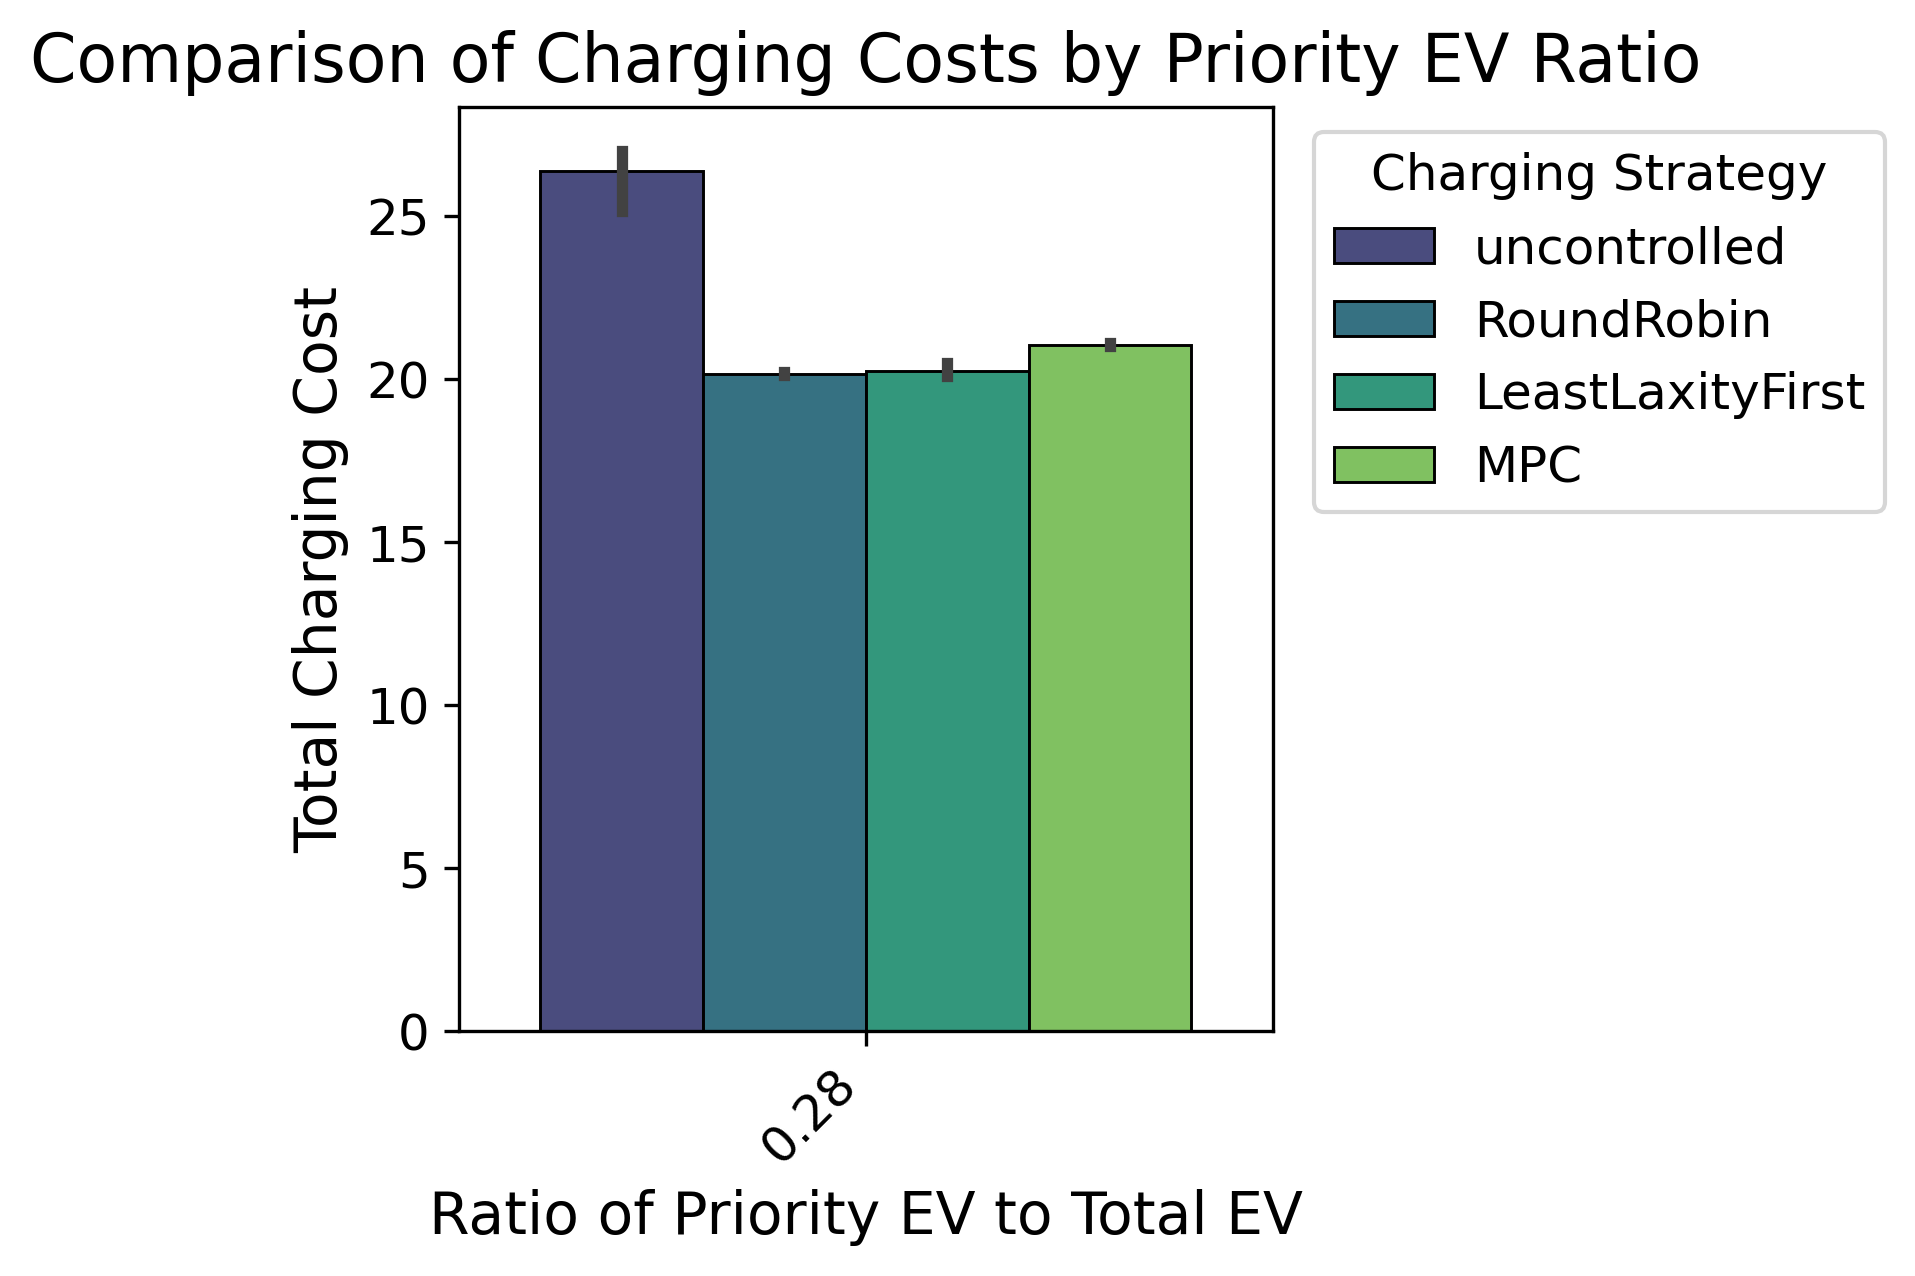

In [32]:
# 3. Create the bar chart
# Adjust figure size: (width, height) in inches.
# Common single-column width is ~3.5 inches, double-column ~7 inches.
fig, ax = plt.subplots(figsize=(3.5, 4)) # Adjust as per journal's requirements

sns.barplot(
    data=df_melted,
    x='priority_ev_ratio_cat', # Use the categorical version for distinct bars
    y='ChargingCost',
    hue='ChargingStrategy',
    palette='viridis', # Good for colorblindness and prints well in grayscale
    ax=ax,
    edgecolor='black', # Add edge color for better bar separation
    linewidth=0.7    # Linewidth for bar edges
)

ax.set_xlabel("Ratio of Priority EV to Total EV") # Updated by rcParams
ax.set_ylabel("Total Charging Cost") # Updated by rcParams
ax.set_title("Comparison of Charging Costs by Priority EV Ratio") # Updated by rcParams
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap

# Improve legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title="Charging Strategy",  bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
# Ensure everything fits and save
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust rect to make space for legend outside plot area if needed

# Save in multiple formats
file_basename = "charging_cost_comparison_plot"
plt.savefig(f"{file_basename}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{file_basename}.pdf", dpi=300, bbox_inches='tight')
plt.savefig(f"{file_basename}.svg", bbox_inches='tight')
print(f"Plot saved as {file_basename}.png, {file_basename}.pdf, and {file_basename}.svg")

plt.show()

# Print the modified melted dataframe to show its structure (optional)
print("\nModified Melted DataFrame structure (first 5 rows):")
print(df_melted.head())